In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import os
from load import get_measures
from load import load_data
from load import train_test_split
from matplotlib import rcParams
import plotly.express as px
import seaborn as sns
from sklearn.metrics import mean_absolute_percentage_error


import warnings # retirar avisos
warnings.filterwarnings('ignore')
rcParams['figure.figsize'] = 25, 15
#plt.style.use('fivethirtyeight') # estilo dos gráficos

In [20]:
# load models forecasts
df = pd.DataFrame()
for file in os.listdir("validation"):
    file_name = "validation/" + file
    df2 = pd.read_csv(file_name, index_col = "date")
    df2.columns = [file[:-7]]
    df = pd.concat([df, df2], axis = 1)

# load "actual" data
n_test = df.shape[0]
test = train_test_split(load_data(), n_test)[1]
test.index = df.index
test.columns = ["test"]

# concatenate forecasts and observed values
df2 = pd.concat([df, test], axis = 1)

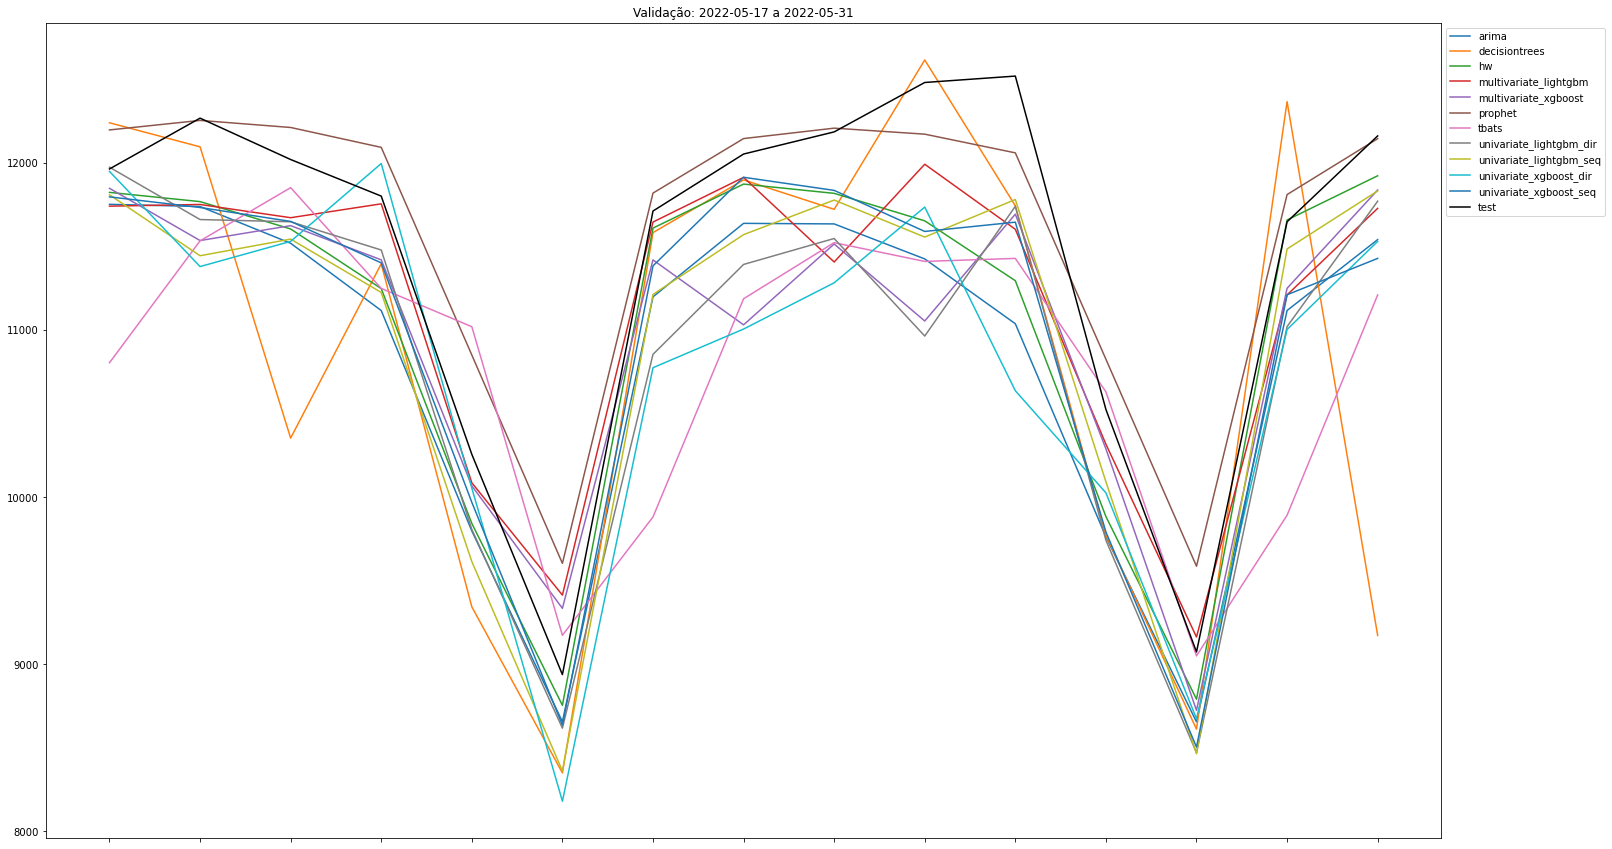

In [21]:
# plot forecasts
for model in df2.columns:
    if model == "test":
        continue
    plt.plot(df2[model], label = model)

# plot observed values
plt.plot(df2["test"], c = "black", label = "test")

# first and last day of the period
date_init = df2.index[0]
date_end = df2.index[-1]
plt.title(f"Validação: {date_init} a {date_end}")

# remove values from X axis
frame1 = plt.gca()  
frame1.axes.xaxis.set_ticklabels([])

# show legend on the right of the plot
plt.legend(bbox_to_anchor = (1,1)) 

plt.show()

In [22]:
# plot using plotly express
df3 = df2.reset_index().melt(id_vars = "date")
px.line(df3, x = "date", y = "value", color= "variable", title=f"Validação: {date_init} a {date_end}")

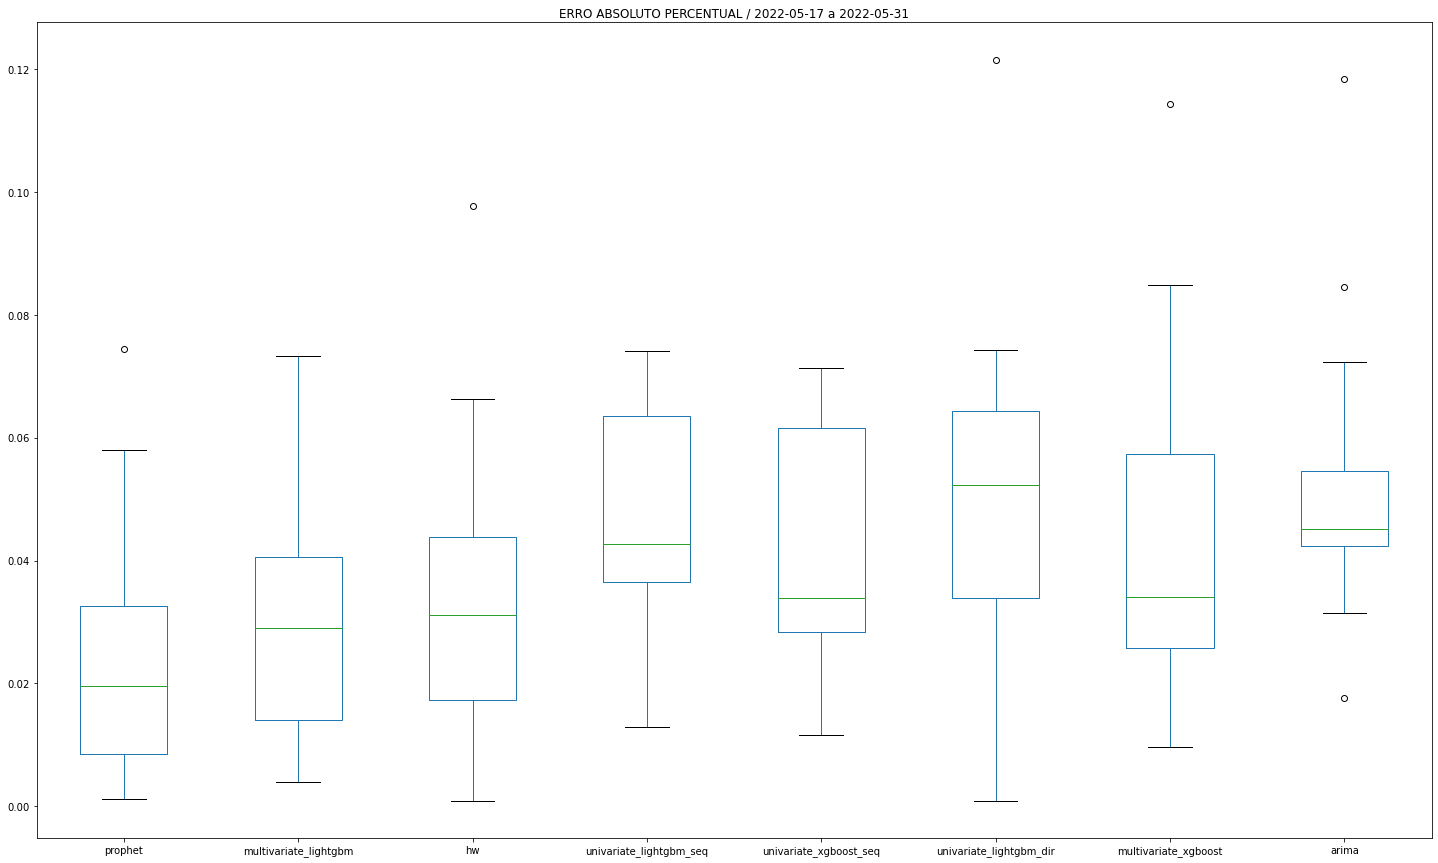

In [23]:
# df de erros por modelo
df_errors = df2.copy(deep=True)
for col in df_errors.columns:
    if col == 'test':
        continue
    else:
        #df_errors[col] = df_errors[col] - df_errors['test']
        df_errors[col] = abs(df_errors[col] - df_errors['test'])/df_errors['test']
df_errors.drop("test", axis = 1, inplace = True)

#sorted_index = df_errors.abs().sum().sort_values().index # ordernar boxplot seguinte por total de erros
sorted_index = df_errors.quantile(.9).sort_values().index # ordernar boxplot seguinte pelo quantil 95
df_sorted=df_errors[sorted_index].abs()

plt.figure()
df_sorted.iloc[:, :8].boxplot(grid = False)

plt.title(f"ERRO ABSOLUTO PERCENTUAL / {date_init} a {date_end}")

plt.show()
#plt.savefig("distribuicao_erros_modelos_fc.jpeg")

### Medidas de acurácia

In [24]:
dict_metrics = []
for model in df2.columns:
    # skips test column
    if model == "test":
        continue
    # for every model's forecast column
    else:
        # create a dict containing the accuracy measures
        measures = get_measures(df2[model], df2["test"])
        # create a column with the model name
        measures["model"] = model
        # append dictionary to list
        dict_metrics.append(measures)
# create dataframe from list of dicionaries
df2_metrics = pd.DataFrame(dict_metrics)   
# set the last column (model name) as the first one for a better view
temp_cols = df2_metrics.columns.to_list()
new_col_order = temp_cols[-1:] + temp_cols[:-1]
df2_metrics = df2_metrics[new_col_order]

df2_metrics.sort_values(by = "mape")

# write excel file
#df2_metrics.to_excel("performance_df.xlsx", index = False)

,model,erro,mae,mse,rmse,mape,smape,r2
5,prophet,1.681396e+06,265.047726,1.120931e+05,334.803025,0.024960,0.024556,0.913118
3,multivariate_lightgbm,2.836398e+06,355.927546,1.890932e+05,434.848452,0.030654,0.031157,0.853436
2,hw,3.863843e+06,405.410422,2.575895e+05,507.532779,0.035019,0.035966,0.800345
10,univariate_xgboost_seq,4.182970e+06,474.408803,2.788647e+05,528.076373,0.041578,0.042664,0.783855
4,multivariate_xgboost,5.786957e+06,517.136381,3.857971e+05,621.125685,0.044284,0.045547,0.700972
8,univariate_lightgbm_seq,4.748333e+06,522.415125,3.165556e+05,562.632696,0.046270,0.047552,0.754641
0,arima,6.808620e+06,601.097052,4.539080e+05,673.726936,0.051888,0.053573,0.648180
7,univariate_lightgbm_dir,6.927535e+06,595.940813,4.618356e+05,679.584900,0.051953,0.053722,0.642036
9,univariate_xgboost_dir,9.800223e+06,682.638703,6.533482e+05,808.299568,0.059020,0.061466,0.493596
1,decisiontrees,1.533928e+07,706.877378,1.022618e+06,1011.245992,0.061969,0.065738,0.207378


In [25]:
#df2_metrics.to_excel("performance_df.xlsx", index = False)

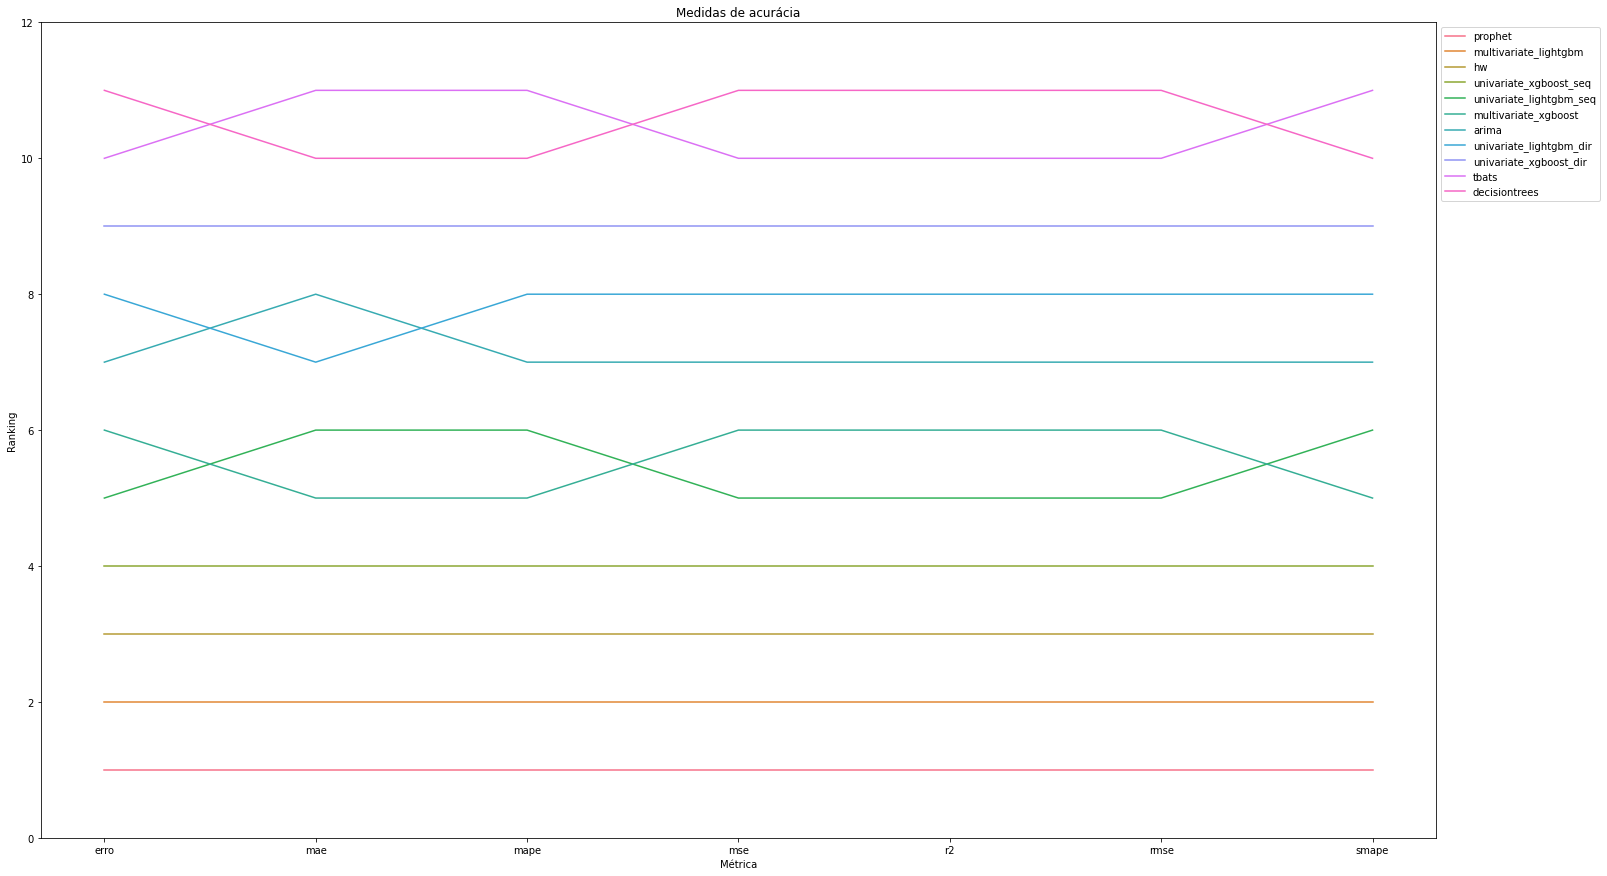

In [26]:
# plot by accuracy measure rank
df2_metrics.loc[:, "r2"] = -df2_metrics.loc[:, "r2"]
df3_metrics = df2_metrics.melt(id_vars = "model", var_name="metric")
df3_metrics["metric_ranking"] = df3_metrics.groupby("metric")["value"].rank("first")
df3_metrics.sort_values(by = ["metric", "metric_ranking"], inplace = True)

plt.figure()

ax = sns.lineplot(data=df3_metrics, x = "metric", y = "metric_ranking", hue="model")
ax.legend(bbox_to_anchor = (1,1))

plt.ylim(0, (df3_metrics["metric_ranking"].max()+1))
plt.ylabel("Ranking")
plt.xlabel("Métrica")
plt.title("Medidas de acurácia")
plt.show()

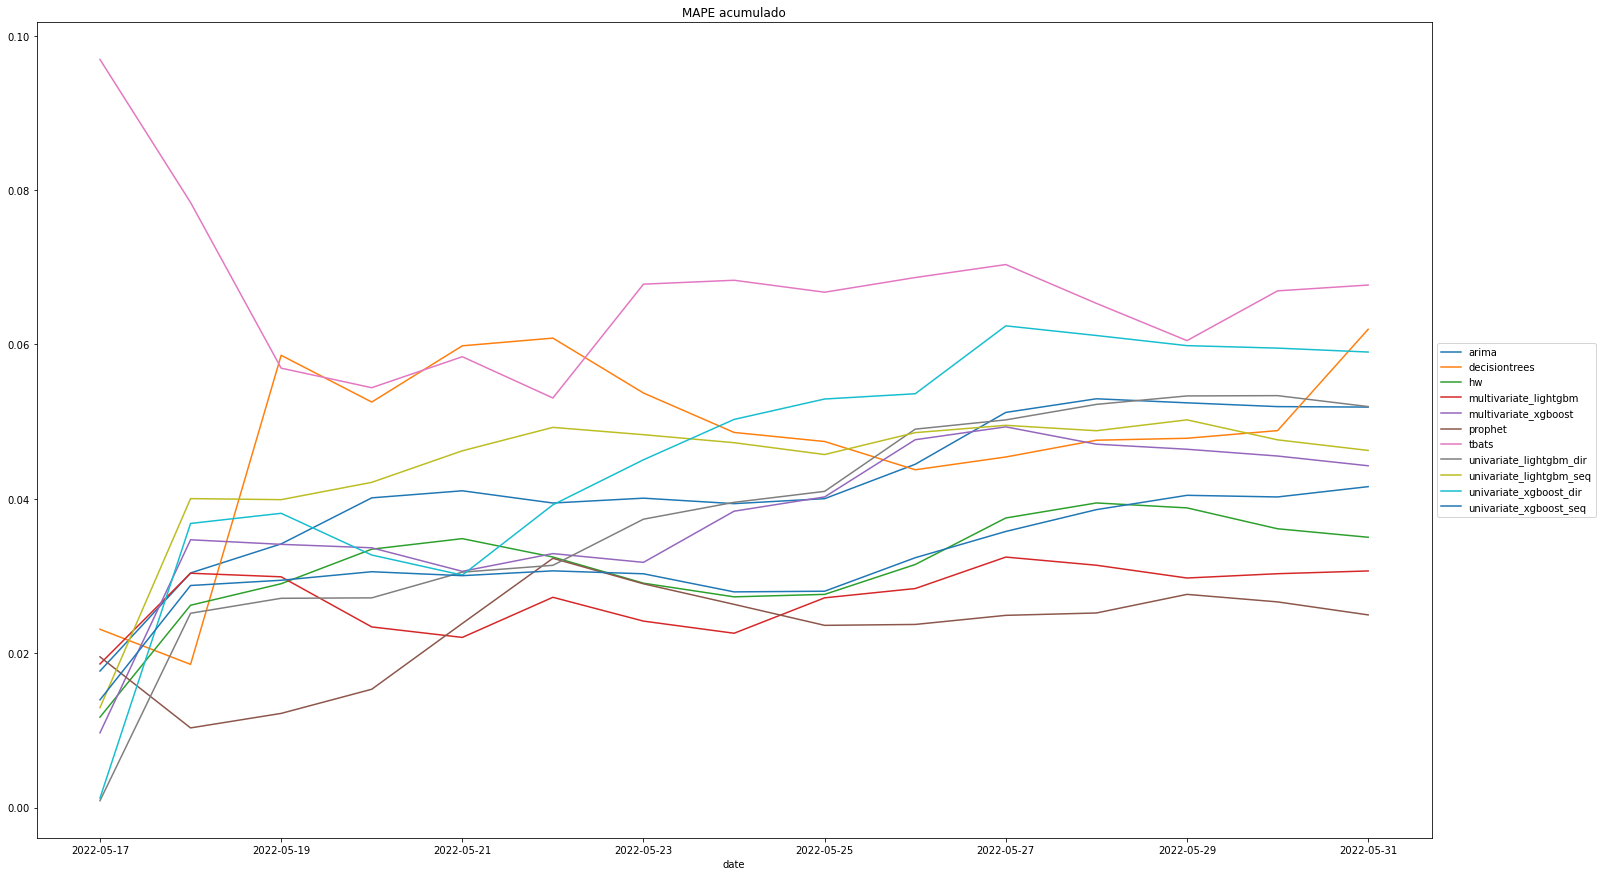

In [27]:
acc_mape_list = []

df2.sort_index(inplace = True) # confirmar ordernação da coluna de data
for col in df2.columns[:-1]: # -1 = coluna "test"
    df_1 = df2.loc[:, [col, "test"]]
    l = []
    for i in range(len(df_1)):
        df_2 = df_1.iloc[:i+1, :]
        acc_mape = mean_absolute_percentage_error(df_2.iloc[:,1], df_2.iloc[:,0])  # test, pred
        l.append(acc_mape)
    l2 = pd.Series(l)
    acc_mape_list.append(l2)
df_acc_mape = pd.concat(acc_mape_list, axis = 1)       
df_acc_mape.columns = df2.columns[:-1]
df_acc_mape.index = test.index
df_acc_mape.plot(title = "MAPE acumulado")
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()
#plt.savefig("forecast_MAPE.jpeg")

In [28]:
df_acc_mape.T

date,2022-05-17,2022-05-18,2022-05-19,2022-05-20,2022-05-21,2022-05-22,2022-05-23,2022-05-24,2022-05-25,2022-05-26,2022-05-27,2022-05-28,2022-05-29,2022-05-30,2022-05-31
arima,0.017684,0.030396,0.034159,0.040127,0.041041,0.039457,0.040084,0.039375,0.040021,0.044479,0.051197,0.052964,0.052440,0.051949,0.051888
decisiontrees,0.023097,0.018549,0.058597,0.052539,0.059828,0.060825,0.053710,0.048602,0.047427,0.043764,0.045422,0.047593,0.047848,0.048839,0.061969
hw,0.011710,0.026212,0.028999,0.033474,0.034840,0.032460,0.029069,0.027299,0.027619,0.031491,0.037519,0.039465,0.038826,0.036119,0.035019
multivariate_lightgbm,0.018606,0.030358,0.029895,0.023401,0.022043,0.027241,0.024154,0.022581,0.027171,0.028374,0.032453,0.031395,0.029738,0.030297,0.030654
multivariate_xgboost,0.009682,0.034693,0.034102,0.033656,0.030605,0.032902,0.031768,0.038397,0.040247,0.047659,0.049326,0.047081,0.046423,0.045546,0.044284
prophet,0.019524,0.010316,0.012196,0.015325,0.023852,0.032292,0.028989,0.026326,0.023605,0.023722,0.024902,0.025208,0.027619,0.026645,0.024960
tbats,0.096931,0.078396,0.056931,0.054399,0.058414,0.053066,0.067816,0.068321,0.066773,0.068675,0.070355,0.065327,0.060501,0.066948,0.067702
univariate_lightgbm_dir,0.000879,0.025171,0.027111,0.027166,0.030496,0.031386,0.037363,0.039544,0.040967,0.049028,0.050229,0.052238,0.053333,0.053370,0.051953
univariate_lightgbm_seq,0.012943,0.040027,0.039892,0.042136,0.046222,0.049258,0.048310,0.047273,0.045739,0.048577,0.049524,0.048824,0.050233,0.047642,0.046270
univariate_xgboost_dir,0.001220,0.036809,0.038124,0.032720,0.030115,0.039225,0.045058,0.050287,0.052934,0.053615,0.062415,0.061163,0.059850,0.059527,0.059020


In [29]:
#df_acc_mape.to_excel("forecast_acc_mape.xlsx")

### Ensemble

In [30]:
# Create combination of every columns
import itertools
df_ensemble = df2.drop("test", axis = 1) # remove test column
ensemble_list = [x for x in df_ensemble.columns] # create a list with the name of every column
combs = []
for r in range(2, len(df_ensemble.columns)+1):
    for comb in itertools.combinations(ensemble_list,r): # r: number of items in the tuple (from 1 to n-columns)
        combs.append(list(comb))

# Create a dictionary with the combinations
ensemble_dict = {}
for comb in combs:
    df_ensemble_subset =  df_ensemble[comb] # select the combination of columns
    df_ensemble_cols = '-'.join(comb) # create string with the names of the columns joined by '-'
    df_ensembled = df_ensemble_subset.mean(axis = 1) # calculate the average of the forecasts at time T
    ensemble_dict[df_ensemble_cols] = df_ensembled # add result to dictionary

# Create a dataframe with the MAPE of each ensemble
ensemble_measures = []
for ensemble, series in ensemble_dict.items(): # tuple with the name of the key and the content
    measure = get_measures(ensemble_dict[ensemble], df2["test"])["mape"] # MAPE 
    new_line = {"ensemble": ensemble, "mape": measure} # ensemble: name; measure: MAPE
    ensemble_measures.append(new_line)
df_ensemble_results =  pd.DataFrame(ensemble_measures).sort_values(by = "mape") # transform list of dictionaries into a DataFrame and order by MAPE
best_ensemble = df_ensemble_results.iloc[0,0] # select the model with smaller MAPE
best_ensemble_series = ensemble_dict[best_ensemble]

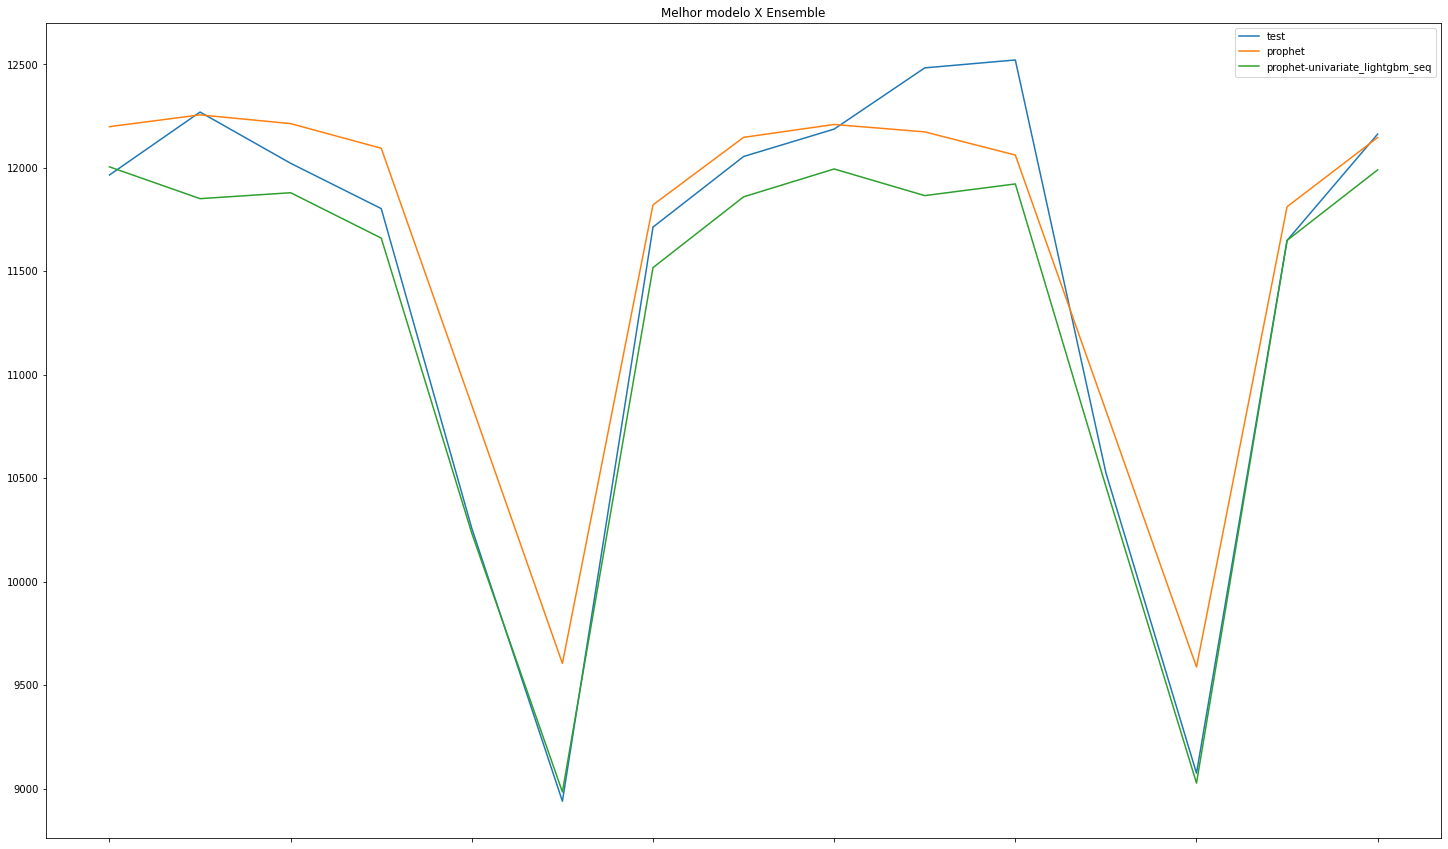

In [31]:
# Plot best single model vs best ensemble
plt.plot(df2["test"], label = "test")

best_model = df2_metrics.sort_values(by="mape").reset_index().loc[0,"model"] # critério: MAPE
plt.plot(df2[best_model], label = best_model)

best_ensemble_series.index = df2["test"].index
plt.plot(best_ensemble_series, label = best_ensemble)

plt.title("Melhor modelo X Ensemble")
plt.legend(bbox_to_anchor = (1,1)) # legenda na lateral direita
frame1 = plt.gca()  # retirar valores do eixo x
frame1.axes.xaxis.set_ticklabels([])

plt.show()

In [32]:
print(f"MAPE modelo ({best_model}): ", df2_metrics.sort_values(by="mape").reset_index().loc[0,"mape"])
print(f"MAPE ensemble ({best_ensemble}): ", df_ensemble_results.iloc[0,1])

MAPE modelo (prophet):  0.02496
MAPE ensemble (prophet-univariate_lightgbm_seq):  0.01603


In [33]:
df4 = df2.copy()
best_ensemble_series.index = df4.index
test_col = df4.test
df4.drop("test", axis=1, inplace=True)
df4["ensemble"] = best_ensemble_series
df4["test"] = test_col

dict_metrics = []
for model in df4.columns:
    # skips test column
    if model == "test":
        continue
    # for every model's forecast column
    else:
        # create a dict containing the accuracy measures
        measures = get_measures(df4[model], df4["test"])
        # create a column with the model name
        measures["model"] = model
        # append dictionary to list
        dict_metrics.append(measures)
# create dataframe from list of dicionaries
df4_metrics = pd.DataFrame(dict_metrics)   
# set the last column (model name) as the first one for a better view
temp_cols = df4_metrics.columns.to_list()
new_col_order = temp_cols[-1:] + temp_cols[:-1]
df4_metrics = df4_metrics[new_col_order]

df4_metrics.sort_values(by = "mape")

,model,erro,mae,mse,rmse,mape,smape,r2
11,ensemble,1.109790e+06,193.217504,7.398602e+04,272.003716,0.016030,0.016275,0.942654
5,prophet,1.681396e+06,265.047726,1.120931e+05,334.803025,0.024960,0.024556,0.913118
3,multivariate_lightgbm,2.836398e+06,355.927546,1.890932e+05,434.848452,0.030654,0.031157,0.853436
2,hw,3.863843e+06,405.410422,2.575895e+05,507.532779,0.035019,0.035966,0.800345
10,univariate_xgboost_seq,4.182970e+06,474.408803,2.788647e+05,528.076373,0.041578,0.042664,0.783855
4,multivariate_xgboost,5.786957e+06,517.136381,3.857971e+05,621.125685,0.044284,0.045547,0.700972
8,univariate_lightgbm_seq,4.748333e+06,522.415125,3.165556e+05,562.632696,0.046270,0.047552,0.754641
0,arima,6.808620e+06,601.097052,4.539080e+05,673.726936,0.051888,0.053573,0.648180
7,univariate_lightgbm_dir,6.927535e+06,595.940813,4.618356e+05,679.584900,0.051953,0.053722,0.642036
9,univariate_xgboost_dir,9.800223e+06,682.638703,6.533482e+05,808.299568,0.059020,0.061466,0.493596


In [34]:
#df4_metrics.to_excel("performance_metrics.xlsx", index=False)

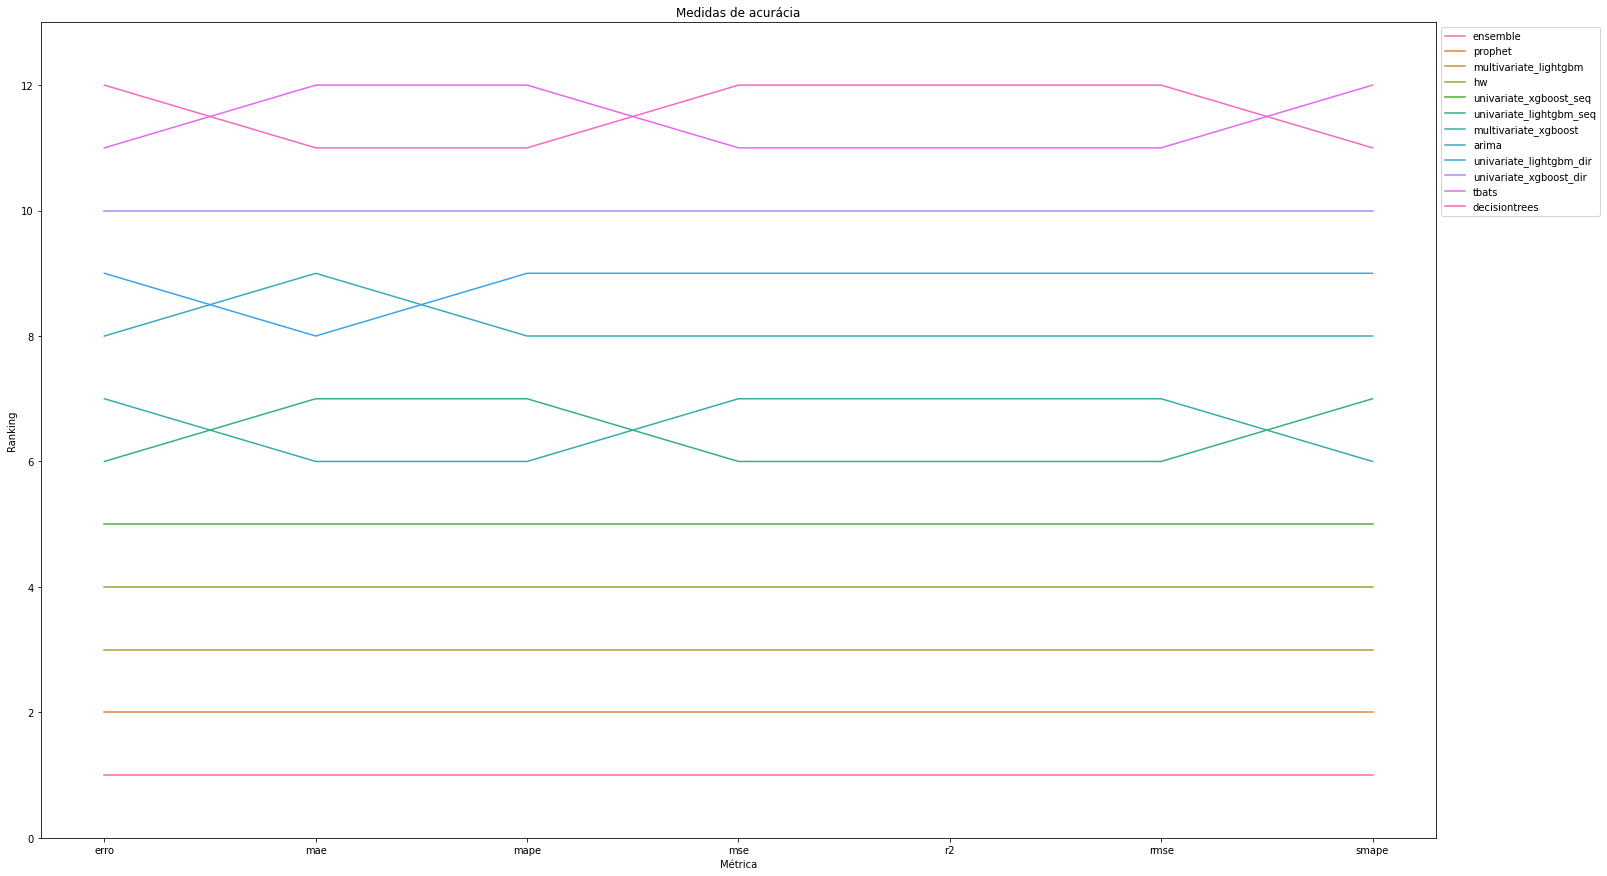

In [35]:
# plot by accuracy measure rank
df4_metrics.loc[:, "r2"] = -df4_metrics.loc[:, "r2"]
df3_metrics = df4_metrics.melt(id_vars = "model", var_name="metric")
df3_metrics["metric_ranking"] = df3_metrics.groupby("metric")["value"].rank("first")
df3_metrics.sort_values(by = ["metric", "metric_ranking"], inplace = True)

plt.figure()

ax = sns.lineplot(data=df3_metrics, x = "metric", y = "metric_ranking", hue="model")
ax.legend(bbox_to_anchor = (1,1))

plt.ylim(0, (df3_metrics["metric_ranking"].max()+1))
plt.ylabel("Ranking")
plt.xlabel("Métrica")
plt.title("Medidas de acurácia")
plt.show()

In [37]:
df_errors.columns

Index(['arima', 'decisiontrees', 'hw', 'multivariate_lightgbm',
       'multivariate_xgboost', 'prophet', 'tbats', 'univariate_lightgbm_dir',
       'univariate_lightgbm_seq', 'univariate_xgboost_dir',
       'univariate_xgboost_seq', 'ensemble'],
      dtype='object')

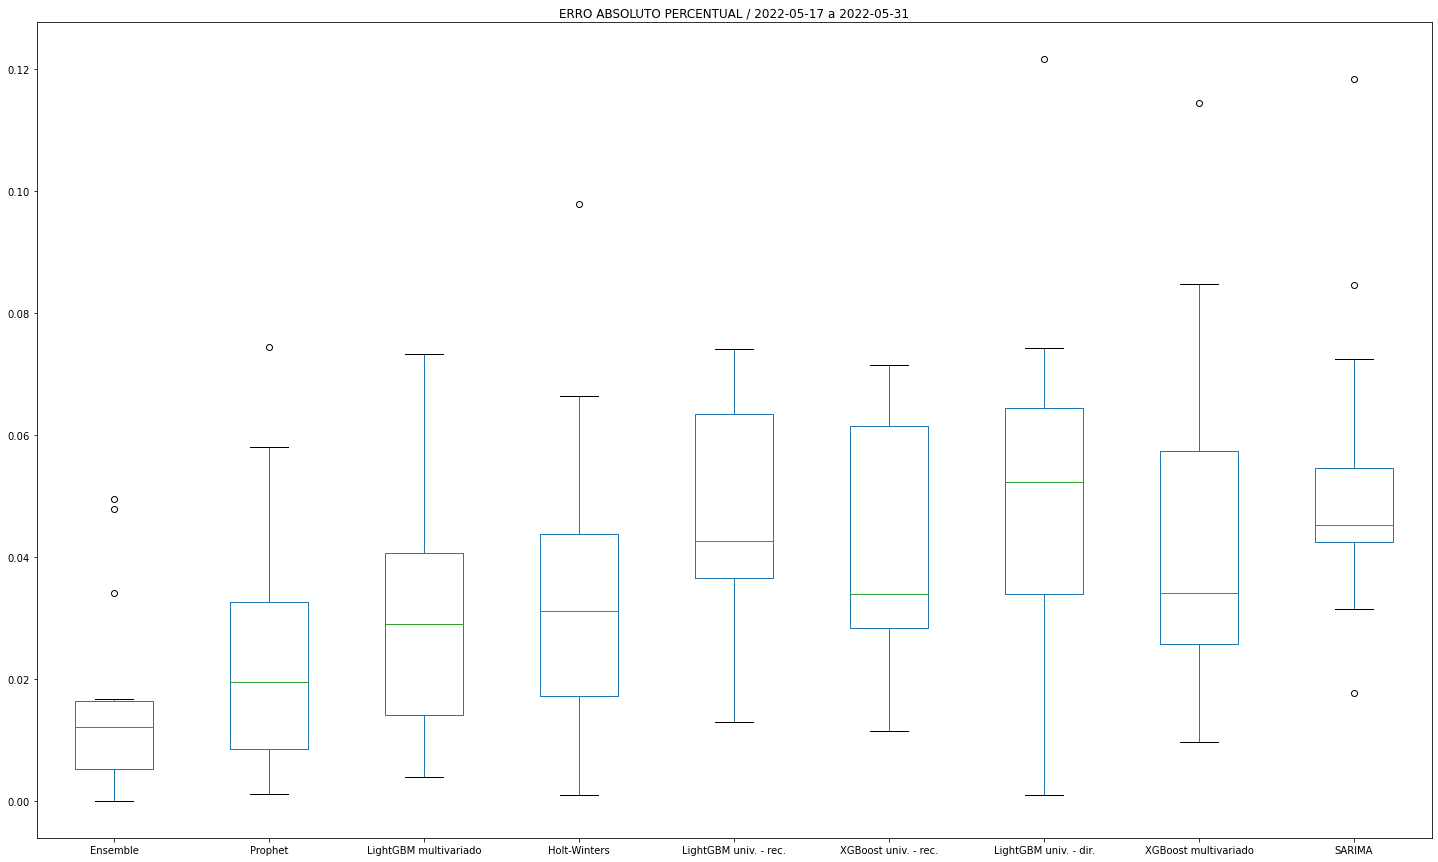

In [39]:
# df de erros por modelo
df_errors = df4.copy(deep=True)
for col in df_errors.columns:
    if col == 'test':
        continue
    else:
        #df_errors[col] = df_errors[col] - df_errors['test']
        df_errors[col] = abs(df_errors[col] - df_errors['test'])/df_errors['test']
df_errors.drop("test", axis = 1, inplace = True)


# RENOMEAR COLUNAS
base_cols = df_errors.columns
format_cols = {"arima": "SARIMA", 
                "decisiontrees": "Árvores de decisão", 
                "hw": "Holt-Winters",
                "multivariate_lightgbm": "LightGBM multivariado",
                "multivariate_xgboost": "XGBoost multivariado",
                "prophet": "Prophet",
                "tbats": "TBATS",
                "univariate_lightgbm_dir": "LightGBM univ. - dir.",
                "univariate_lightgbm_seq": "LightGBM univ. - rec.",
                "univariate_xgboost_dir": "XGBoost univ. - dir.",
                "univariate_xgboost_seq": "XGBoost univ. - rec.",
                "ensemble": "Ensemble"
            }
#

#sorted_index = df_errors.abs().sum().sort_values().index # ordernar boxplot seguinte por total de erros
sorted_index = df_errors.quantile(.9).sort_values().index # ordernar boxplot seguinte pelo quantil 95
df_sorted=df_errors[sorted_index].abs()

plt.figure()
df_sorted.rename(format_cols, axis=1, inplace = True)
df_sorted.iloc[:, :9].boxplot(grid = False)

plt.title(f"ERRO ABSOLUTO PERCENTUAL / {date_init} a {date_end}")

plt.show()

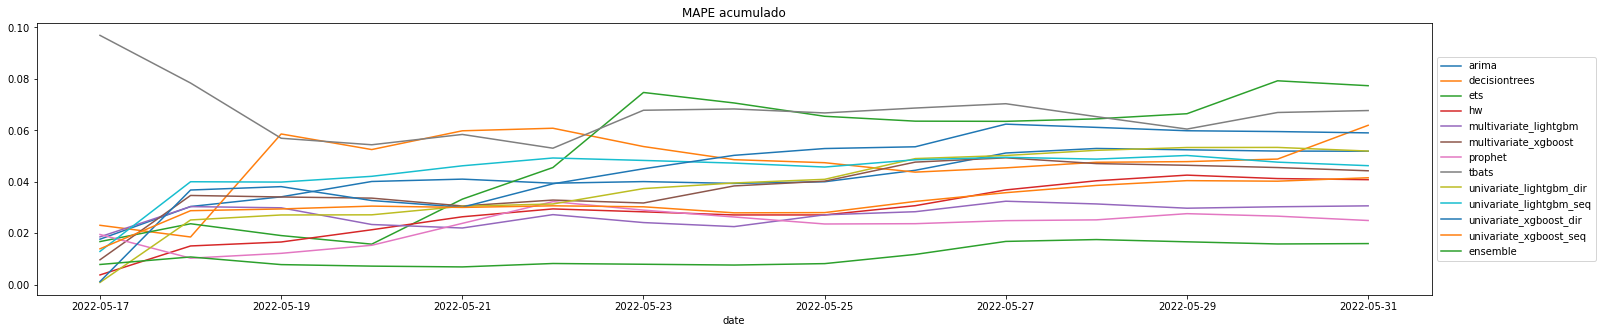

In [18]:
acc_mape_list = []

df4.sort_index(inplace = True) # confirmar ordernação da coluna de data
for col in df4.columns[:-1]: # -1 = coluna "test"
    df_1 = df4.loc[:, [col, "test"]]
    l = []
    for i in range(len(df_1)):
        df_2 = df_1.iloc[:i+1, :]
        acc_mape = mean_absolute_percentage_error(df_2.iloc[:,1], df_2.iloc[:,0])  # test, pred
        l.append(acc_mape)
    l2 = pd.Series(l)
    acc_mape_list.append(l2)
df_acc_mape = pd.concat(acc_mape_list, axis = 1)       
df_acc_mape.columns = df4.columns[:-1]
df_acc_mape.index = test.index
df_acc_mape.plot(title = "MAPE acumulado")
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()

In [19]:
df_acc_mape.T

date,2022-05-17,2022-05-18,2022-05-19,2022-05-20,2022-05-21,2022-05-22,2022-05-23,2022-05-24,2022-05-25,2022-05-26,2022-05-27,2022-05-28,2022-05-29,2022-05-30,2022-05-31
arima,0.017684,0.030396,0.034159,0.040127,0.041041,0.039457,0.040084,0.039375,0.040021,0.044479,0.051197,0.052964,0.052440,0.051949,0.051888
decisiontrees,0.023097,0.018549,0.058597,0.052539,0.059828,0.060825,0.053710,0.048602,0.047427,0.043764,0.045422,0.047593,0.047848,0.048839,0.061969
ets,0.016765,0.023694,0.019100,0.015769,0.033259,0.045549,0.074727,0.070650,0.065475,0.063576,0.063506,0.064471,0.066469,0.079268,0.077360
hw,0.003800,0.015063,0.016602,0.021358,0.026405,0.029461,0.028332,0.027121,0.027122,0.030720,0.036849,0.040400,0.042595,0.041258,0.040827
multivariate_lightgbm,0.018606,0.030358,0.029895,0.023401,0.022043,0.027241,0.024154,0.022581,0.027171,0.028374,0.032453,0.031395,0.029738,0.030297,0.030654
multivariate_xgboost,0.009682,0.034693,0.034102,0.033656,0.030605,0.032902,0.031768,0.038397,0.040247,0.047659,0.049326,0.047081,0.046423,0.045546,0.044284
prophet,0.019524,0.010316,0.012196,0.015325,0.023852,0.032292,0.028989,0.026326,0.023605,0.023722,0.024902,0.025208,0.027619,0.026645,0.024960
tbats,0.096931,0.078396,0.056931,0.054399,0.058414,0.053066,0.067816,0.068321,0.066773,0.068675,0.070355,0.065327,0.060501,0.066948,0.067702
univariate_lightgbm_dir,0.000879,0.025171,0.027111,0.027166,0.030496,0.031386,0.037363,0.039544,0.040967,0.049028,0.050229,0.052238,0.053333,0.053370,0.051953
univariate_lightgbm_seq,0.012943,0.040027,0.039892,0.042136,0.046222,0.049258,0.048310,0.047273,0.045739,0.048577,0.049524,0.048824,0.050233,0.047642,0.046270


<AxesSubplot:xlabel='date'>

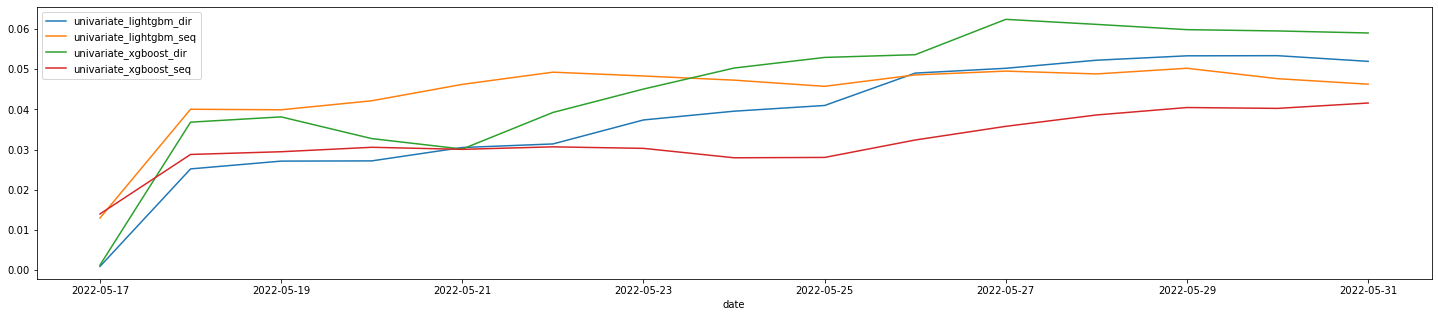

In [24]:
df_acc_mape[["univariate_lightgbm_dir","univariate_lightgbm_seq", "univariate_xgboost_dir", "univariate_xgboost_seq"]].plot()